In [1]:
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import NMF,PCA
from sklearn.metrics import accuracy_score, r2_score
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
#load datasets
data = pd.read_csv('data.csv',index_col=0).set_index('uniqueid')
locations = pd.read_csv('locations.csv')

In [3]:
# join locations data
main = data.join(locations.set_index('uniqueid')[['geographiclevel','stateabbr','cityname']]).copy()

# Only keep census level data
main = main[main['geographiclevel'] == 'Census Tract']

In [4]:
main = main.drop(['datavaluetypeid','geographiclevel','stateabbr','cityname'],axis=1).reset_index().set_index('uniqueid')
main.head()

,populationcount,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CHD,CHECKUP,...,KIDNEY,LPA,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST
uniqueid,,,,,,,,,,,,,,,,,,,,,
0107000-01073000100,3042.0,0.239,0.325,0.101,0.462,0.800,0.052,0.127,0.080,0.763,...,0.036,0.423,0.742,0.188,0.467,0.760,0.196,0.504,0.055,0.302
0107000-01073000300,2735.0,0.288,0.313,0.108,0.456,0.803,0.046,0.118,0.082,0.738,...,0.038,0.437,0.740,0.185,0.470,0.732,0.202,0.494,0.057,0.333
0107000-01073000400,3338.0,0.261,0.346,0.095,0.501,0.820,0.052,0.130,0.088,0.775,...,0.040,0.449,0.736,0.191,0.488,0.728,0.211,0.525,0.065,0.360
0107000-01073000500,2864.0,0.281,0.378,0.086,0.543,0.840,0.058,0.134,0.108,0.788,...,0.048,0.471,0.732,0.194,0.499,0.708,0.231,0.526,0.082,0.402
0107000-01073000700,2577.0,0.318,0.385,0.074,0.554,0.833,0.057,0.143,0.119,0.787,...,0.057,0.508,0.705,0.216,0.528,0.676,0.258,0.541,0.096,0.458


In [5]:
# Contextualy irrelevant features
#dropping data irrelevant
drop_data = np.array(['MAMMOUSE','PAPTEST','BPMED','TEETHLOST','DENTAL']) 


# Drop effects/irrelevant features
mainData = main.drop(np.concatenate([drop_data]),axis=1)

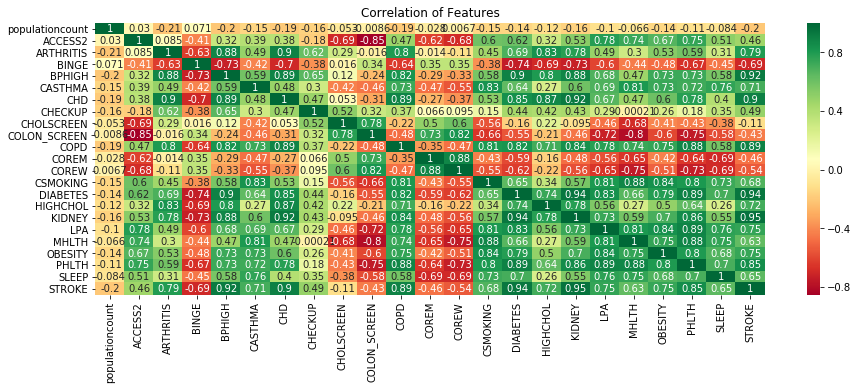

In [6]:
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(mainData.drop('CANCER',axis=1).corr(),annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()

In [7]:
#drop correlations not required as of now
mainData.drop(['LPA','COREW','populationcount','CHOLSCREEN', 'ACCESS2', 'CHD', 'PHLTH', 'COLON_SCREEN', 'MHLTH','COPD'],axis=1,inplace=True)

In [8]:
# y is the feature in question (CANCER)
# X is the other features in question

y = mainData['CANCER']
X = mainData.drop('CANCER',axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.25)

In [9]:
#check for any missing/abnormal data
summaryofmainData = sm.OLS(ytrain,Xtrain).fit()
abnormalData = summaryofmainData.resid[summaryofmainData.resid <= -.10]

In [10]:
#find the summary of abnormal data in the dataset
a = np.empty(len(Xtrain.index.values),dtype=np.bool)
for i,j in enumerate(Xtrain.index.values):
    a[i] = True if j in abnormalData.index.values else False
summaryofabnormalData = sm.OLS(ytrain[~a],Xtrain[~a]).fit()

In [11]:
#Obtain Coefficient confidence intervals
alp = .05
confidenceinterval = summaryofabnormalData.conf_int(alpha=alp)
confidenceinterval.columns =['low','high']
confidenceinterval.sort_values('low',ascending=False)

,low,high
KIDNEY,0.740055,0.799872
STROKE,0.225967,0.266613
ARTHRITIS,0.161638,0.167759
HIGHCHOL,0.111503,0.116221
BPHIGH,0.074323,0.081224
CHECKUP,0.034798,0.037957
BINGE,0.016885,0.021105
COREM,-0.020653,-0.017349
OBESITY,-0.046399,-0.042552
SLEEP,-0.047793,-0.043581


In [12]:
## R2 scoring for cross_val_score scoring
def scorer(t,X,y):
    t.fit(X,y)
    ypred = t.predict(X)
    return r2_score(y,ypred)



In [13]:
#Set Model for Regression and Print
snf = LinearRegression()

snf.fit(Xtrain[~a],ytrain[~a])

print('Model Accuracy :')
print('Linear Regression R2: {:.4f}'.format(snf.score(Xtrain[~a],ytrain[~a])))
print('Cross Fold Validation: ')
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(snf,Xtrain[~a],ytrain[~a],cv= 20,scoring=scorer)))
pd.DataFrame(snf.coef_,index=Xtrain[~a].columns,columns=['Coefs']).sort_values('Coefs',ascending=False).sort_values('Coefs',ascending=False)

Model Accuracy :
Linear Regression R2: 0.9534
Cross Fold Validation: 
Linear Regression Cross Val Score: [0.95129119 0.96023873 0.95546101 0.95172346 0.95840328 0.95474819
 0.95071321 0.95278396 0.94396559 0.95479395 0.9550239  0.95936513
 0.95674104 0.9512097  0.95926936 0.95424274 0.95144749 0.95033017
 0.95360734 0.95218433]


,Coefs
KIDNEY,0.639907
STROKE,0.288111
ARTHRITIS,0.181788
HIGHCHOL,0.091484
BPHIGH,0.081130
CHECKUP,0.029428
BINGE,0.004885
COREM,-0.028582
OBESITY,-0.042867
SLEEP,-0.053652


In [16]:
data = pd.read_csv('data.csv')
dataDef = pd.read_csv('data_def.csv')
locations = pd.read_csv('locations.csv')
data2 = data.set_index('uniqueid').join(locations.set_index('uniqueid')[['geographiclevel','stateabbr','cityname']]).copy()
data2 = data2[data2['geographiclevel'] == 'Census Tract']
data2 = data2.drop(['Unnamed: 0','datavaluetypeid','geographiclevel'],axis=1).reset_index()


In [17]:
dataMelt = data2.melt(id_vars=['uniqueid','stateabbr','cityname','populationcount'],var_name='measureid')
dataMelt.head()

,uniqueid,stateabbr,cityname,populationcount,measureid,value
0,0107000-01073000100,AL,Birmingham,3042.0,ACCESS2,0.239
1,0107000-01073000300,AL,Birmingham,2735.0,ACCESS2,0.288
2,0107000-01073000400,AL,Birmingham,3338.0,ACCESS2,0.261
3,0107000-01073000500,AL,Birmingham,2864.0,ACCESS2,0.281
4,0107000-01073000700,AL,Birmingham,2577.0,ACCESS2,0.318


In [27]:
filt1 = dataMelt['measureid']=='SLEEP'
filt2 = dataMelt['measureid']=='LPA'
filt3 = dataMelt['measureid']=='OBESITY'
filt4 = dataMelt['measureid']=='CANCER'
filtered = dataMelt[(filt1)|(filt2)|(filt3)|(filt4)]
pivoted = filtered.reset_index().pivot_table('value',['uniqueid','populationcount','stateabbr','cityname'],'measureid')

In [28]:
def plot(x,y,size=100):
    obesity = pivoted['OBESITY']
    lpa = pivoted['LPA']
    slope,intercept = np.polyfit(x,y,1)
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    plt.plot(x,y,marker='.',linestyle='none',alpha=.4)
    xminmax = np.array([x.min(),x.max()])

    for i in range(size):
        #List of temp index
        inds = np.arange(len(x))

        #Random Index Locations
        b_inds = np.random.choice(inds,len(inds))

        #Select x & y lines based on random index
        tx = x[b_inds].values
        ty = y[b_inds].values

        #generate random regression line & plot
        tslope,tint = np.polyfit(tx,ty,1)
        plt.plot(xminmax,xminmax*tslope+tint,color='green',alpha=.2,linewidth=.25)

    #Plot observed regression line
    plt.plot(xminmax,xminmax*slope+intercept,color='red',linewidth=.5)
    return fig


Text(0,0.5,'OBESITY')

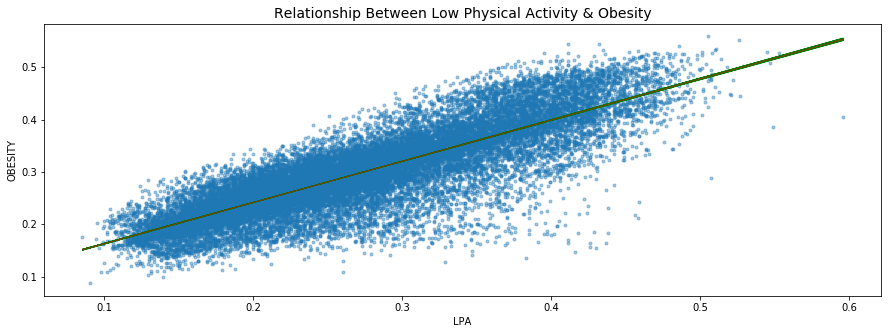

In [29]:
fig = plot(pivoted['LPA'],pivoted['OBESITY'],1000)

#plot labels & title
plt.title('Relationship Between Low Physical Activity & Obesity',fontsize=14)
plt.xlabel('LPA')
plt.ylabel('OBESITY')


Text(0,0.5,'OBESITY')

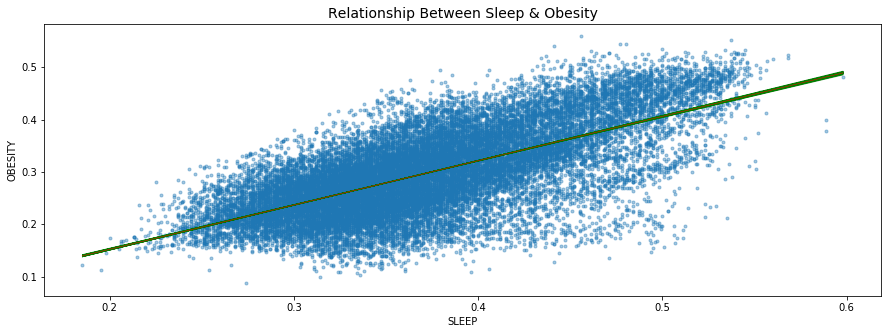

In [30]:
fig2 = plot(pivoted['SLEEP'],pivoted['OBESITY'],1000)

#plot labels & title
plt.title('Relationship Between Sleep & Obesity',fontsize=14)
plt.xlabel('SLEEP')
plt.ylabel('OBESITY')





Text(0,0.5,'OBESITY')

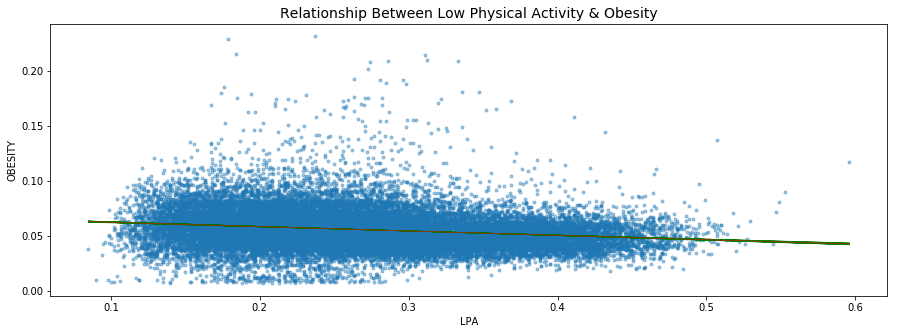

In [31]:
fig3 = plot(pivoted['LPA'],pivoted['CANCER'],1000)

#plot labels & title
plt.title('Relationship Between Low Physical Activity & Cancer',fontsize=14)
plt.xlabel('LPA')
plt.ylabel('CANCER')





Text(0,0.5,'CANCER')

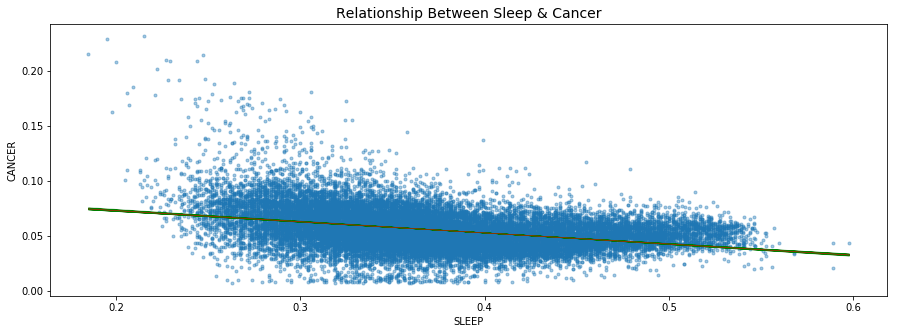

In [32]:
fig3 = plot(pivoted['SLEEP'],pivoted['CANCER'],1000)

#plot labels & title
plt.title('Relationship Between Sleep & Cancer',fontsize=14)
plt.xlabel('SLEEP')
plt.ylabel('CANCER')




